In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [ ]:
window_size = 48
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 50
predict_values_exp = 6000
lag_exp=72

In [ ]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [ ]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled


In [ ]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [ ]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]


In [ ]:
import pandas as pd
series = pd.read_csv('/content/drive/My Drive/T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
#del series['Air temperature | (\'C)']
del series['LV ActivePower (kW)']
del series['Wind Direction (°)']
del series['Theoretical_Power_Curve (KWh)']
series.head()

,Wind Speed (m/s)
Date/Time,
01 01 2018 00:00,5.311336
01 01 2018 00:10,5.672167
01 01 2018 00:20,5.216037
01 01 2018 00:30,5.659674
01 01 2018 00:40,5.577941


In [ ]:
for i in range(0,10):
  series = series[:-1]
series.head()

,Wind Speed (m/s)
Date/Time,
01 01 2018 00:00,5.311336
01 01 2018 00:10,5.672167
01 01 2018 00:20,5.216037
01 01 2018 00:30,5.659674
01 01 2018 00:40,5.577941


In [ ]:
series.shape

(50520, 1)

In [ ]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [ ]:


# split data into train and test-sets
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[:], supervised_values[:]
#print(test_scaled)

In [ ]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


Epoch 1/1
50519/50519 [==============================] - 233s 5ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 227s 4ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 226s 4ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 228s 5ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 232s 5ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 227s 4ms/step - loss: 0.0018
Epoch 1/1
50519/50519 [==============================] - 228s 5ms/step - loss: 0.0018


In [ ]:
                      # walk-forward validation on the test data
predictions = list()
expectations = list()
for i in range(len(test_scaled)-window_size):
    window_prediction_frame = test_scaled
    test_pred = list()
    for j in range(window_size):
        X, y = window_prediction_frame[i, 0:-1], window_prediction_frame[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
        '''# Start Debug prints
        print("X: %", X)
        print("yhat: %", yhat)
        # End Debug prints'''
        # Replacing value in test scaled with the predicted value.
        test_pred = [yhat] + test_pred 
        if len(test_pred) > lag_exp+1:
            test_pred = test_pred[:-1]
        if j+1<len(window_prediction_frame):
            if j+1 > lag_exp+1:
                window_prediction_frame[j+1] = test_pred
            else:
                window_prediction_frame[j+1] = np.concatenate((test_pred, window_prediction_frame[j+1, j+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1-50519- window_size]
    predictions.append(yhat)
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Hour=1, Predicted=5.434281, Expected=4.172731
Hour=2, Predicted=5.808715, Expected=4.502260
Hour=3, Predicted=5.353614, Expected=5.285727
Hour=4, Predicted=5.785985, Expected=5.882676
Hour=5, Predicted=5.705380, Expected=5.832772
Hour=6, Predicted=5.745386, Expected=6.083103
Hour=7, Predicted=5.934482, Expected=5.896152
Hour=8, Predicted=5.442682, Expected=5.456291
Hour=9, Predicted=5.721771, Expected=6.039964
Hour=10, Predicted=5.650670, Expected=7.657910
Hour=11, Predicted=5.867223, Expected=8.315362
Hour=12, Predicted=6.067144, Expected=8.209787
Hour=13, Predicted=6.683746, Expected=8.624151
Hour=14, Predicted=6.329822, Expected=7.930004
Hour=15, Predicted=6.643192, Expected=5.749671
Hour=16, Predicted=6.770531, Expected=4.824298
Hour=17, Predicted=6.521158, Expected=4.591996
Hour=18, Predicted=6.579197, Expected=4.792756
Hour=19, Predicted=6.547534, Expected=4.478368
Hour=20, Predicted=6.585147, Expected=4.600290
Hour=21, Predicted=6.407479, Expected=4.505049
Hour=22, Predicted=7.0

KeyboardInterrupt: ignored

In [ ]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))

Mean Absolute Percent Error:  47.85676992911516


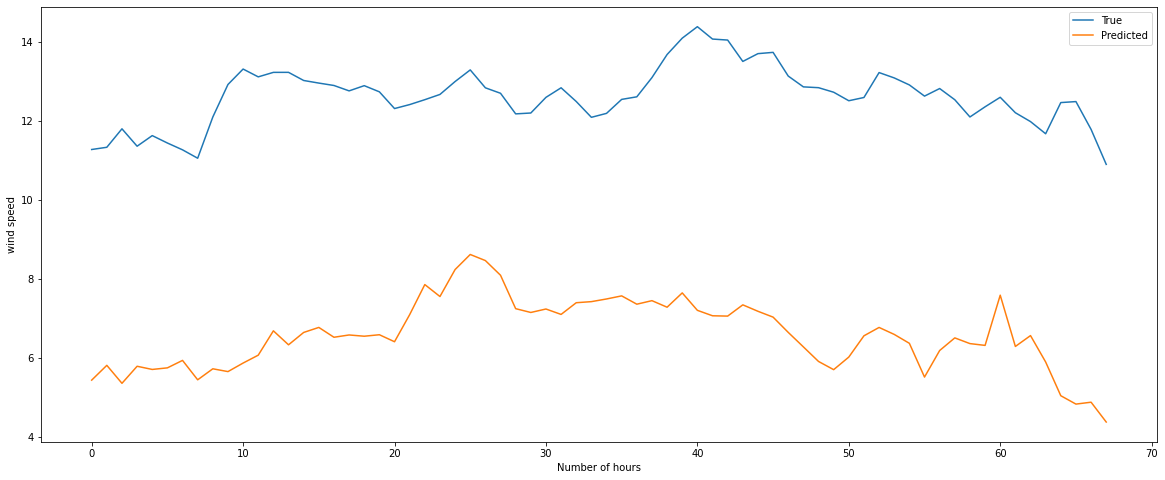

In [ ]:
# line plot of observed vs predicted
fig = pyplot.figure(figsize=(20,8))
pyplot.plot(expectations[0:1000], label="True")
pyplot.plot(predictions[0:1000], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("wind speed")
pyplot.show()

In [ ]:
import pickle 

In [ ]:
Pkl_Filename = "Pickle_RL1_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [ ]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR1_Model = pickle.load(file)

Pickled_LR_Model

In [ ]:
score = Pickled_LR_Model.score(train, test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_LR_Model.predict(test)  

Ypredict